#Dataset loading and preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

path = '/content/drive/My Drive/Tickets'

## General preparation:
First of all, we need to drop duplicates, transfom each data field to appropriate type, so that it would be more efficient to work with them:

In [0]:
dtypes = {'id': 'Int32', 'n_tickets': 'Int64', type: 'str'}
df_tickets = pd.read_csv(path+'/data/orders_tickets.csv', dtype=dtypes)
df_tickets.drop_duplicates(inplace=True)

parse_dates = ['date']
dtypes = {'id': 'Int32', 'channel_id': 'Int32'}
df_channels = pd.read_csv(path+'/data/orders_channels.csv', dtype=dtypes, parse_dates=parse_dates)
df_channels.drop_duplicates(inplace=True)

dtypes = {'id': 'Int32', 'country_1': 'Int32', 'country_2': 'Int32'}
df_country = pd.read_csv(path+'/data/orders_country.csv', dtype=dtypes, na_values = {'xx'})
df_country.drop_duplicates(inplace=True)


##Task-specific preparation:
We create field 'country' that will be considered as country for which we make prediction. We sort dataframe by `'date'` field and reindex by this field. Unknown values for countries and channels are replaced by `-1`:

In [0]:
tickets = df_tickets.set_index('id')
channels = df_channels.set_index('id')
country = df_country.set_index('id')
df = channels.join([tickets, country])
df.sort_values('date', ascending=False, inplace=True)
df.set_index('date', drop = True, inplace = True)
df['country'] = df['country_1'].copy()
df['country'].fillna(df['country_2'], inplace=True)
df['country'].fillna(-1, inplace=True)
df['channel_id'].fillna(-1, inplace=True)

## Country and channel train pairs generation
Our task suppose the model should make predictions for marginal distribution of country and channel variables. Let's generate their pairs with the condition that the difference between first and last day of solding tickets is more or equal to 10. This condition will allow to create a target variable as the prediction for future 10 days. 

In [0]:
def generate_train_pairs(df):
  pairs = []
  for channel, country in [(x, y) for x in df.channel_id.unique() for y in df.country.unique()]:
    if channel == -1 or country == -1:
      continue
    if df[(df.country==country) & (df.channel_id==channel)].empty:
      continue
    first = df[(df.country==country) & (df.channel_id==channel)].index.min()
    last = df[(df.country==country) & (df.channel_id==channel)].index.max()
    if last-first <= pd.Timedelta(days=10):
      continue
    pairs.append((channel, country))
  return pairs

pairs = generate_train_pairs(df)

#Visualizing dataset and working out strategy for model creation

##Visualization of generaral trends of ticket sales
We see that there is clear periodicity in total ticket sales per day. It makes sense to include total sales field to our data:

Text(0.5, 1.0, 'Total number of sold tickets per day')

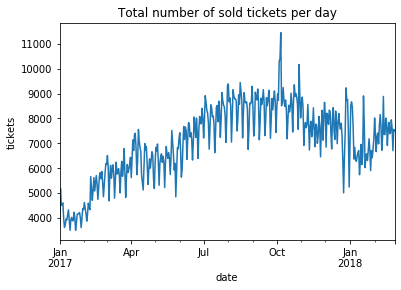

In [19]:
import matplotlib.pyplot as plt
df.groupby(['date'])['n_tickets'].sum().astype('int64').plot()

plt.xlabel('date')
plt.ylabel('tickets')
plt.title('Total number of sold tickets per day')


## Visualization of marginal trends

Let's visualize trends for specific countries and channels as they must index our main vectors as input into model. Let's take a few random country and channel pairs. We can see some periodicity here as well:




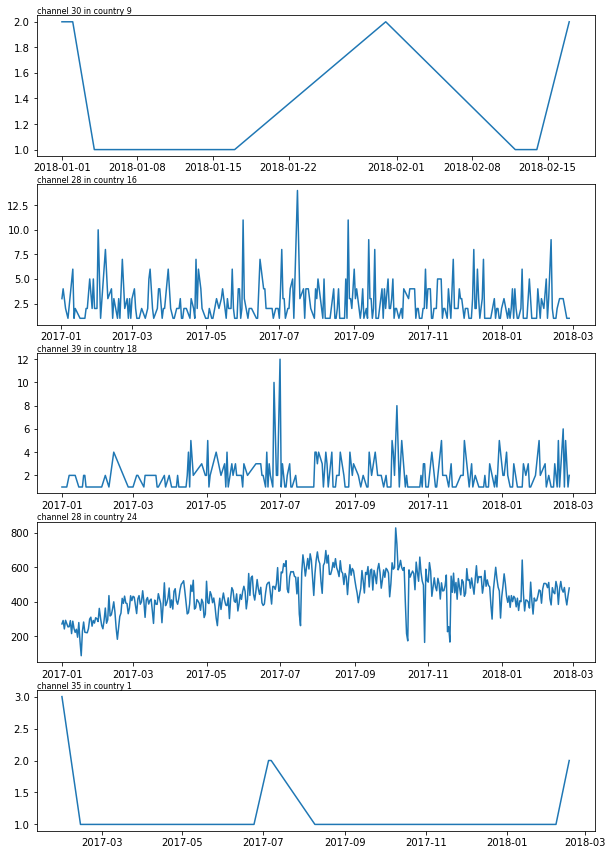

In [65]:
import random

plt.figure(figsize=[10,15])
def visualize_marginal(number, pairs):
  for i in range(number):
    channel, country = random.choice(pairs)
    plt.subplot(number, 1, i+1)
    plt.plot(df[(df.country==country) & (df.channel_id==channel)].groupby(['date'])['n_tickets'].sum().astype('float64'))
    plt.title('channel '+str(channel) +' in country ' + str(country), y=0.5, loc='left', fontsize=8, pad = 72)
visualize_marginal(number)  

# Algorithm selection, further data preparation and training

We saw periodicy in data, so our model should be sequence model to be able to predict periodic structure in data. Firstly, let's remove columns that don't need to be included into vectors and also let's change` 'type'` field to boolean to facilitate and speed up work with data:

In [0]:
df.drop(['country_1', 'country_2'], axis=1, inplace=True)
df['type'][df.type == 'pax'] = 1
df['type'][df.type == 'other'] = 0

df['type'] = df['type'].astype('bool')


## Sequences generation
Now, let's generate sequences of total tickets sold in 10 days for channel and country pairs of more than 10 days that we have already prepared. 

Each sequence will consist of **3 steps**(total of 30 days), although it's possible to select different length. In addition to total tickets sold for pair, we'll generate such fields as: number of `'pax'` and `'other'` types sold in 10 days(in general, for current country, channel, pair) and total number of tickets(in general, for current country, channel, pair). We'll have 12 features in general. 

Each number of tickets will be scaled by dividing by the number of days for which tickets were available for sale. We'll also generate target variable 'y' that will specify the number of tickets sold in the next 10 days in certain country and channel pair. We'll use parallelization to speed up the process: 

In [0]:
import random
from joblib import Parallel, delayed

def get_sequences(df, pairs, length, n_jobs=-1):
  first_all = df.index.min()

  
  def create_seq(channel, country):
    rows = []
    df_marginal = df[(df.country==country) & (df.channel_id==channel)]
    first_country = df[df.country == country].index.min()
    first_channel = df[df.channel_id == channel].index.min()
    first = df_marginal.index.min()
    last = df_marginal.index.max()

    while last > first+pd.Timedelta(days=10):
      y = df_marginal[(df_marginal.index <= last) & (df_marginal.index > last-pd.Timedelta(days=10))]['n_tickets'].sum()
      end = last
      for i in range(length):
        end -= pd.Timedelta(days=10)
        before = end - pd.Timedelta(days=10)
        sequence = df_marginal[(df_marginal.index <= end) & (df_marginal.index > before)]    
        pax = sequence[sequence.type == True]['n_tickets'].sum()/max(1, (min(10, (end-first).days)))
        other = sequence[sequence.type == False]['n_tickets'].sum()/max(1, (min(10, (end-first).days)))
        n_tickets = (pax+other)/max(1, (min(10, (end-first).days)))

        df_all = df[(df.index <= end) & (df.index > before)]  
        overall_tickets = df_all['n_tickets'].sum()/max(1, (min(10, (end-first_all).days)))
        pax_overall = df_all[df_all.type == True]['n_tickets'].sum()/max(1, (min(10, (end-first_all).days)))
        other_overall = df_all[df_all.type == False]['n_tickets'].sum()/max(1, (min(10, (end-first_all).days)))
        df_country = df_all[df_all.country == country]
        country_tickets = df_country['n_tickets'].sum()/max(1, (min(10, (end-first_country).days)))
        pax_country_tickets = df_country[df_country.type == True]['n_tickets'].sum()/max(1, (min(10, (end-first_country).days)))
        other_country_tickets = df_country[df_country.type == False]['n_tickets'].sum()/max(1, (min(10, (end-first_country).days)))
        df_channel = df_all[df_all.channel_id == channel]
        channel_tickets = df_channel['n_tickets'].sum()/max(1, (min(10, (end-first_channel).days)))
        pax_channel_tickets = df_channel[df_channel.type == True]['n_tickets'].sum()/max(1, (min(10, (end-first_channel).days)))
        other_channel_tickets = df_channel[df_channel.type == False]['n_tickets'].sum()/max(1, (min(10, (end-first_channel).days)))

        rows.append({'pax': pax, 'other': other, 'n_tickets': n_tickets, 'y': y,
                    'overall_tickets': overall_tickets, 'country_tickets': country_tickets,
                    'pax_country_tickets': pax_country_tickets, 
                     'other_country_tickets': other_country_tickets,
                    'channel_tickets': channel_tickets,
                    'pax_channel_tickets': pax_channel_tickets,
                    'other_channel_tickets': other_channel_tickets,
                    'pax_overall': pax_overall,
                    'other_overall': other_overall}) 
        
      last -= pd.Timedelta(days=1)
    return rows
    
  
  rows = Parallel(n_jobs=-1, max_nbytes=None, verbose=0)(delayed(create_seq)(channel, country) for channel, country in pairs)
  rows = [item for sublist in rows for item in sublist]
  df_sequence = pd.DataFrame(rows)
    
  df_sequence = df_sequence.reindex(index=df_sequence.index[::-1])
  return df_sequence

df_sequence = get_sequences(df, pairs, 3, 1)

df_sequence.to_csv(path+'/data/seq_final.csv', index=False)

In [70]:
df_sequence.head()

,channel_tickets,country_tickets,n_tickets,other,other_channel_tickets,other_country_tickets,other_overall,overall_tickets,pax,pax_channel_tickets,pax_country_tickets,pax_overall,y
0,0.000,3225.6,0.0,0.0,0.000,600.7,1082.6,5808.3,0.0,0.00,2624.9,4725.7,0
1,0.000,3181.2,0.0,0.0,0.000,594.0,1072.2,5760.1,0.0,0.00,2587.2,4687.9,0
2,0.375,3210.7,1.0,0.0,0.125,567.1,1055.3,5806.8,1.0,0.25,2643.6,4751.5,0
3,0.000,3235.3,0.0,0.0,0.000,603.5,1090.6,5863.9,0.0,0.00,2631.8,4773.3,0
4,0.000,3161.4,0.0,0.0,0.000,587.4,1054.5,5671.0,0.0,0.00,2574.0,4616.5,0


## Data reshaping and separating X and y
Let's reshape our sequence array to 3d, so that it would be suitable for training:

In [0]:
def get_X_y(df_sequence, length):
  y = np.array([df_sequence['y']]).reshape(int(len(df_sequence)/length), length)
  y = y[:, 0]
  df_sequence.drop(['y'], axis=1, inplace=True)
  X = np.array(df_sequence).reshape((int(len(df_sequence)/length), length, 12))
  return (X,y)

X, y = get_X_y(df_sequence, 3)

In [27]:
len(X)

114470

## Algorithm selection and training

Since our dataset is pretty large(more than 100000 of 3 steps sequencies), it's reasonable to use deep learing algorithm. **LSTM** seems like a good choice, since it's sequential algorithm and it's scalable to larger sequencies(in case we'll decide to increase length of sequencies by generating them in function `def get_sequences(df, pairs, length)`) due to short-long term memory unit. 

Firstly, we'll **split dataset** into train and test sets, then we'll **scale values** with `MinMaxScaler(feature_range=(0, 1))`. Scalling will speed up the training process. For optimization, we chose **mean absolute error** as *loss function* (mean squared errror wasn't chosen, because we don't know if larger values are more important, and also we wan't our model to work well for new channel and country pairs that recently appeared and therefore may have small target value) and **adam optimizer** to adapt learning rate:  

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from matplotlib import pyplot as plt


def split_dataset(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

  scalers = {}
  for i in range(X_train.shape[1]):
      scalers[i] = MinMaxScaler(feature_range=(0, 1))
      X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

  for i in range(X_test.shape[1]):
      X_test[:, i, :] = scalers[i].transform(X_test[:, i, :])
  return X_train, X_test, y_train, y_test, scalers

X_train, X_test, y_train, y_test, scalers = split_dataset(X, y)

def train_model(X_train, X_test, y_train, y_test, batch_size, epochs):
  model = Sequential()
  model.add(LSTM(70, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  model.compile(loss='mae', optimizer='adam')
  # fit network
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=10, shuffle=True)
  # plot history
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()
  return model, history

model, history = train_model(X_train, X_test, y_train, y_test, 8, 300)
  
  

## Hyperparameters tuning and visulization of training

Firstly, we chose `batch_size=32`. Training quickly reached its limit with `val_loss: 52.92`. Then batch size was reduced to 8, so that `val_loss: 34.23` was achieved. 

Afterwards, **dropout layer** was added to regularize neural network. After some experiments, value ` Dropout(0.2)` was chosen. We see at the plot how train and test losses merge after 30 epochs. Test loss is always higher due to dropout layer in train network:

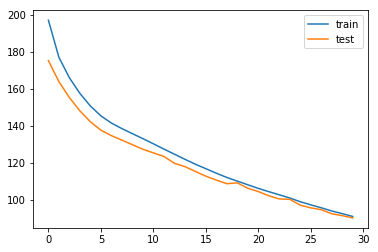

In [30]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Error checking
Let's check mean absolute error on the test set. We that mean_absolute_error is 15.5. Let's compare it with mean = 202.35. It means error percentage for expected value is about 7%: 

`mean_absolute_error(y_test, preds)/np.mean(y_test)`:

In [32]:
from sklearn.metrics import mean_absolute_error

preds = model.predict(X_test, batch_size=8)

mean_absolute_error(y_test, preds)

15.508055628490421

In [33]:
np.mean(y_test)

202.35616318686118

In [35]:
mean_absolute_error(y_test, preds)/np.mean(y_test)

0.07663742672453154

#Generating output

##Generate predict pairs and dataset for prediction
First let's generate predict pairs for all channel and country pairs that are not empty. Then, we'll generate sequences for the **latest date** of each pair:

In [0]:
from joblib import Parallel, delayed

def generate_predict_pairs(df):
  pairs = []
  for channel, country in [(x, y) for x in df.channel_id.unique() for y in df.country.unique()]:
    if channel == -1 or country == -1:
      continue
    if df[(df.country==country) & (df.channel_id==channel)].empty:
      continue
    pairs.append((channel, country))
  return pairs

pairs_predict = generate_predict_pairs(df)


def generate_input(df, length, pairs, n_jobs):
  first_all = df.index.min()  
  def create_seq(channel, country):
    rows = []
    df_marginal = df[(df.country==country) & (df.channel_id==channel)]
    first_country = df[df.country == country].index.min()
    first_channel = df[df.channel_id == channel].index.min()
    first = df_marginal.index.min()
    last = df_marginal.index.max()
    end = last    
   
    for i in range(length):
      before = end - pd.Timedelta(days=10)
      sequence = df_marginal[(df_marginal.index <= end) & (df_marginal.index > before)]    
      pax = sequence[sequence.type == True]['n_tickets'].sum()/max(1, (min(10, (end-first).days)))
      other = sequence[sequence.type == False]['n_tickets'].sum()/max(1, (min(10, (end-first).days)))
      n_tickets = (pax+other)/max(1, (min(10, (end-first).days)))

      df_all = df[(df.index <= end) & (df.index > before)]  
      overall_tickets = df_all['n_tickets'].sum()/max(1, (min(10, (end-first_all).days)))
      pax_overall = df_all[df_all.type == True]['n_tickets'].sum()/max(1, (min(10, (end-first_all).days)))
      other_overall = df_all[df_all.type == False]['n_tickets'].sum()/max(1, (min(10, (end-first_all).days)))
      df_country = df_all[df_all.country == country]
      country_tickets = df_country['n_tickets'].sum()/max(1, (min(10, (end-first_country).days)))
      pax_country_tickets = df_country[df_country.type == True]['n_tickets'].sum()/max(1, (min(10, (end-first_country).days)))
      other_country_tickets = df_country[df_country.type == False]['n_tickets'].sum()/max(1, (min(10, (end-first_country).days)))
      df_channel = df_all[df_all.channel_id == channel]
      channel_tickets = df_channel['n_tickets'].sum()/max(1, (min(10, (end-first_channel).days)))
      pax_channel_tickets = df_channel[df_channel.type == True]['n_tickets'].sum()/max(1, (min(10, (end-first_channel).days)))
      other_channel_tickets = df_channel[df_channel.type == False]['n_tickets'].sum()/max(1, (min(10, (end-first_channel).days)))

      rows.append({'pax': pax, 'other': other, 'n_tickets': n_tickets, 
                  'overall_tickets': overall_tickets, 'country_tickets': country_tickets,
                  'pax_country_tickets': pax_country_tickets, 
                   'other_country_tickets': other_country_tickets,
                  'channel_tickets': channel_tickets,
                  'pax_channel_tickets': pax_channel_tickets,
                  'other_channel_tickets': other_channel_tickets,
                  'pax_overall': pax_overall,
                  'other_overall': other_overall,
                 'date': last,
                 'country': country,
                 'channel': channel}) 
      end -= pd.Timedelta(days=10)
        
      
    return rows
    
  
  rows = Parallel(n_jobs=n_jobs, verbose=0, max_nbytes=None)(delayed(create_seq)(channel, country) for channel, country in pairs)
  rows = [item for sublist in rows for item in sublist]
  df_sequence = pd.DataFrame(rows)
    
  df_sequence = df_sequence.reindex(index=df_sequence.index[::-1])
  return df_sequence

df_predict = generate_input(df, 3, pairs_predict, 1)
      

In [74]:
df_predict[:7]

,channel,channel_tickets,country,country_tickets,date,n_tickets,other,other_channel_tickets,other_country_tickets,other_overall,overall_tickets,pax,pax_channel_tickets,pax_country_tickets,pax_overall
1412,47,0.0,4,588.8,2017-03-19,0.00,0.0,0.0,105.0,994.7,5434.2,0.0,0.0,483.8,4439.5
1411,47,0.0,4,662.7,2017-03-19,0.00,0.0,0.0,126.2,1106.6,5898.9,0.0,0.0,536.5,4792.3
1410,47,2.0,4,618.1,2017-03-19,2.00,1.0,1.0,116.3,1036.4,5643.2,1.0,1.0,501.8,4606.8
1409,47,0.0,24,3519.1,2017-05-10,0.00,0.0,0.0,645.7,1158.3,6349.8,0.0,0.0,2873.4,5191.5
1408,47,0.0,24,3269.2,2017-05-10,0.00,0.0,0.0,598.0,1085.2,6007.1,0.0,0.0,2671.2,4921.9
1407,47,0.1,24,3516.8,2017-05-10,0.01,0.0,0.0,645.3,1166.5,6377.4,0.1,0.1,2871.5,5210.9
1406,32,0.0,4,886.4,2017-08-09,0.00,0.0,0.0,157.0,1442.1,8004.0,0.0,0.0,729.4,6561.9


In [44]:
len(df_predict)/3

471.0

##Scaling and preparing output and input dataset for prediction

Now, lets prepare dataset ouput dateset with required fields. And let's prepare input dataset the same way we prepared training dataset, **using the same scaler** that was generated from the training data:

In [0]:
def get_template(df_sequence, length):
  df_pred = pd.DataFrame()
  df_sequence = df_sequence[['date','country','channel']]  
  cols = df_sequence.columns
  for col in cols:        
      x = np.array([df_sequence[col]]).reshape(int(len(df_sequence)/length), length)
      x = x[:, 0]
      df_pred[col] = x  

  return df_pred

def get_X(df_sequence, length, scalers=scalers):
  df_sequence = df_sequence.drop(['date','country','channel'], axis=1)
  X = np.array(df_sequence).reshape((int(len(df_sequence)/length), length, 12))
  for i in range(X.shape[1]):
      X[:, i, :] = scalers[i].transform(X[:, i, :])  
  return X

df_pred = get_template(df_predict, 3)
X_pred = get_X(df_predict, 3, scalers)

In [0]:
preds = model.predict(X_pred,batch_size=8)

In [0]:
df_pred['n_tickets'] = preds

In [52]:
df_pred['n_tickets'].mean()

136.23329162597656

In [0]:
model.save('/content/drive/My Drive/Tickets/model/model')

In [0]:
df_pred.to_csv('/content/drive/My Drive/Tickets/output/output.csv', index=False)

## Further possible improvements

It's worth experimenting further with different sequence length(so far we've tried only 3 and 12), other hyperpameters(batch_size, epochs, layers size). It's also worth experimenting with adding additional layers to network (multilayer perceptron, convolutional layers), choosing different optimizer. Other algorims may be worth trying(xgboost, lightxgb). Model ensemble creation may be possible.

In [75]:
df_pred[:10]

,date,country,channel,n_tickets
0,2017-03-19,4,47,0.462585
1,2017-05-10,24,47,0.147171
2,2017-08-09,4,32,-0.001250
3,2017-08-10,24,32,1.002268
4,2017-08-09,11,32,0.002072
5,2017-09-23,24,13,0.547565
6,2017-03-26,29,42,0.028068
7,2017-07-27,21,42,-0.002961
8,2017-10-05,23,42,-0.002519
9,2017-07-27,27,42,0.003017


#Conclusion
Model was created by using sequences of length 3, generated for 10 days(30 days in total). LSTM neural network was used with adam optimizer and mean absolute error as loss function. Hyperparameters were selected,  mean_absolute_error of **15.5** was achived after training for 300 epochs. Mean of the target value of the test dataset is:  202.35. It means error percentage for expected value is about **7%**. Futher improvement possibilities were shown.